# 1) Imports

In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 88 from PyObject
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
from os import walk
from os.path import join, exists
from utils import nomes, save_dataframe_as_feather, decode_rle

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN, OPTICS, KMeans, AgglomerativeClustering, cluster_optics_dbscan

import tensorflow
from tensorflow.keras.preprocessing import image

# 2) Carregar dataset

In [5]:
dataset = pd.read_feather('train_com_imagens.feather')
dataset = dataset.sample(frac=1)
dataset

,id,class,segmentation,image,width,height
25546,case78_day22_slice_0083,large_bowel,None,.\train\case78\case78_day22\scans\slice_0083_3...,360,310
13493,case110_day16_slice_0095,large_bowel,32935 6 33294 11 33653 14 34013 17 34372 19 34...,.\train\case110\case110_day16\scans\slice_0095...,360,310
60296,case130_day20_slice_0099,small_bowel,30532 7 30674 5 30797 19 30938 8 31062 22 3120...,.\train\case130\case130_day20\scans\slice_0099...,266,266
109627,case67_day12_slice_0142,large_bowel,None,.\train\case67\case67_day12\scans\slice_0142_2...,266,266
97956,case81_day30_slice_0047,stomach,None,.\train\case81\case81_day30\scans\slice_0047_2...,266,266
...,...,...,...,...,...,...
108961,case131_day19_slice_0111,stomach,None,.\train\case131\case131_day19\scans\slice_0111...,360,310
54000,case6_day20_slice_0047,small_bowel,None,.\train\case6\case6_day20\scans\slice_0047_360...,360,310
17708,case122_day27_slice_0022,large_bowel,None,.\train\case122\case122_day27\scans\slice_0022...,266,266
68116,case40_day0_slice_0024,large_bowel,None,.\train\case40\case40_day0\scans\slice_0024_26...,266,266


# 3) Clusterizar imagens p/ gerar exemplos de teste

In [16]:
distancia_vizinho = 50
n_vizinhos = 100
max_clusters = 25

def new_cluster_model(image_as_arr):
	# Demora menos mas consumo de memória é n
	# return DBSCAN(
	# 	eps=distancia_vizinho,
	# 	min_samples=n_vizinhos,
	# ).fit_predict(image_as_arr)

	return KMeans(
		n_clusters=max_clusters,
	).fit_predict(image_as_arr)

	# Demora consideravelmente mas não consome tanta memória
	# return OPTICS(
	# 	cluster_method='dbscan',
	# 	eps=distancia_vizinho,
	# 	min_samples=n_vizinhos,
	# 	n_jobs=-2
	# ).fit_predict(image_as_arr)

	# Demora + consumo de memória
	# return AgglomerativeClustering(
	# 	n_clusters=10,
	# ).fit_predict(image_as_arr)

In [17]:
class Counter:
    _count = 0
    @staticmethod
    def get():
        Counter._count += 1
        return Counter._count
    
    @staticmethod
    def reset():
        Counter._count = 0


def clustering(linha, redimensionar=False):
    largura, altura = linha['width'], linha['height']
    # largura, altura = 100, 100

    img = image.load_img(
        linha['image'],
        target_size=(largura, altura),
        color_mode='grayscale'
    )

    # Para realizar o clustering de uma imagem
    # Precisa de uma matriz das posicoes + uma dimensao para cores
    image_as_arr = image.img_to_array(img).reshape(largura * altura, 1)

    print(Counter.get(), end=', ')
    
    # Rodar clustering
    cluster_array = new_cluster_model(image_as_arr)

    if not redimensionar:
        return cluster_array

    cluster_array = cluster_array.reshape(largura, altura)
    cluster_array = np.expand_dims(cluster_array, axis=2)
    cluster_img_raw = image.array_to_img(cluster_array)
    cluster_img_raw.save('cluster.png')

    # Abrir cluster novamente para redimensionar
    cluster_img = image.load_img(
        'cluster.png',
        target_size=(largura, altura),
        color_mode='grayscale'
    )
    return image.img_to_array(cluster_img).reshape(largura * altura, 1)

In [19]:
# Limitar os dados por questão de tempo
# limite_dados = 10000
# limite_dados = 1000
# limite_dados = 100
limite_dados = 25
# limite_dados = 5
# limite_dados = 1

df_dados = pd.concat([
	dataset[dataset['class'] == 'stomach'].sample(limite_dados),
	# dataset[dataset['class'] == 'small_bowel'].sample(limite_dados),
	# dataset[dataset['class'] == 'large_bowel'].sample(limite_dados),
])

df_dados['class'].value_counts()

df_dados['clusters'] = df_dados.apply(clustering, axis=1)
df_dados.head()

2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 

,id,class,segmentation,image,width,height,clusters
4729,case65_day28_slice_0082,stomach,None,.\train\case65\case65_day28\scans\slice_0082_2...,266,266,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ..."
59122,case24_day0_slice_0119,stomach,None,.\train\case24\case24_day0\scans\slice_0119_26...,266,266,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
50963,case40_day17_slice_0083,stomach,17462 7 17725 13 17989 17 18253 20 18518 22 18...,.\train\case40\case40_day17\scans\slice_0083_2...,266,266,"[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 1..."
78781,case119_day25_slice_0116,stomach,None,.\train\case119\case119_day25\scans\slice_0116...,266,266,"[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1..."
96109,case49_day15_slice_0113,stomach,None,.\train\case49\case49_day15\scans\slice_0113_3...,360,310,"[17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 1..."


## Visualização

In [20]:
linha = df_dados[df_dados['segmentation'].notnull()].sample(n=1).iloc[0]
largura, altura = linha['width'], linha['height']

print('Número clusters:', pd.DataFrame(linha['clusters']).value_counts().keys().shape)
print('Tem segmentação:', bool(linha['segmentation']))

Número clusters: (25,)
Tem segmentação: True


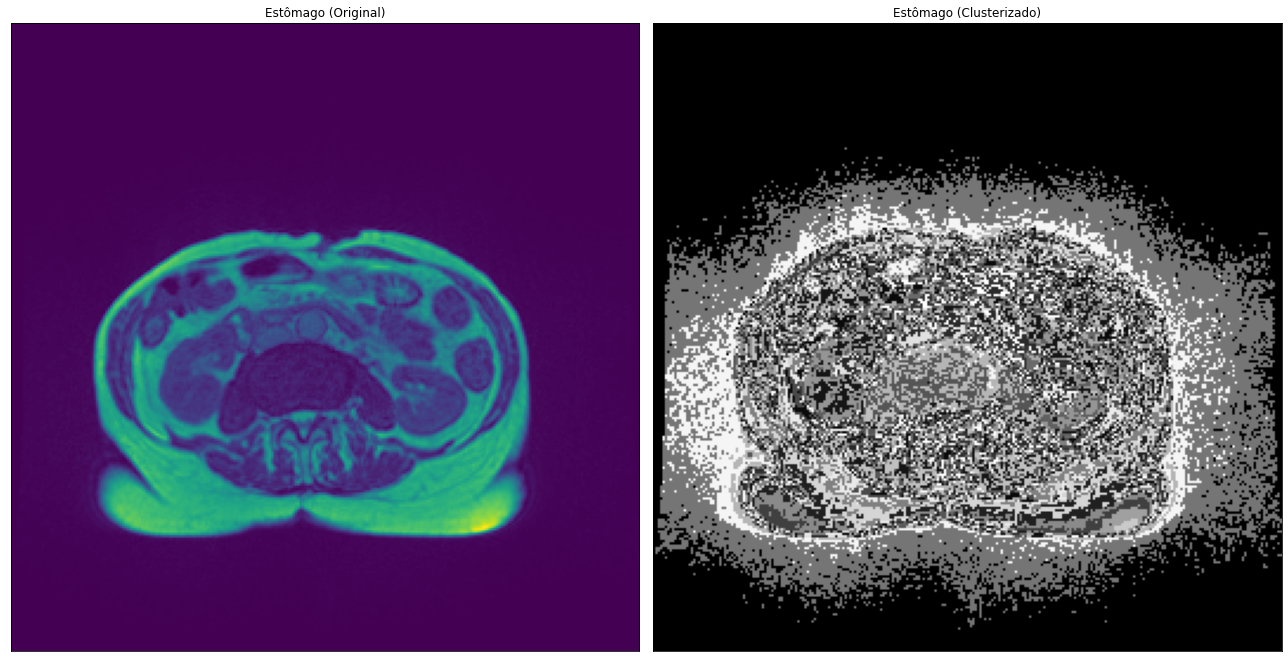

In [21]:
fig = plt.figure(figsize=(18, 10))
fig.patch.set_alpha(1)

# Desenho original
ax = plt.subplot(1, 2, 1)
ax.imshow(plt.imread(linha['image']))
plt.xticks([])
plt.yticks([])
plt.title(nomes[linha['class']] + ' (Original)')

# Desenhar todos os clusters juntos
ax = plt.subplot(1, 2, 2)
clusters = linha['clusters'].reshape(largura, altura)
ax.imshow(clusters, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title(nomes[linha['class']] + ' (Clusterizado)')
plt.tight_layout()

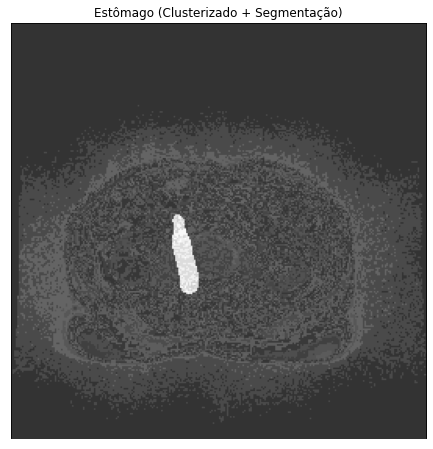

In [25]:
# Desenhar todos os clusters juntos + segmentação
fig = plt.figure(figsize=(18, 10))
fig.patch.set_alpha(1)
if linha['segmentation']:
	ax = plt.subplot(1, 3, 3)

	ax.imshow(clusters, cmap='gray', alpha=0.5)

	segmentation = linha['segmentation']
	segmentation_rle = decode_rle(segmentation, shape=(altura, largura))

	ax.imshow(
		segmentation_rle,
		cmap='gray',
		alpha=0.6
	)
	plt.xticks([])
	plt.yticks([])
	plt.title(nomes[linha['class']] + ' (Clusterizado + Segmentação)')

	plt.tight_layout()

plt.show()

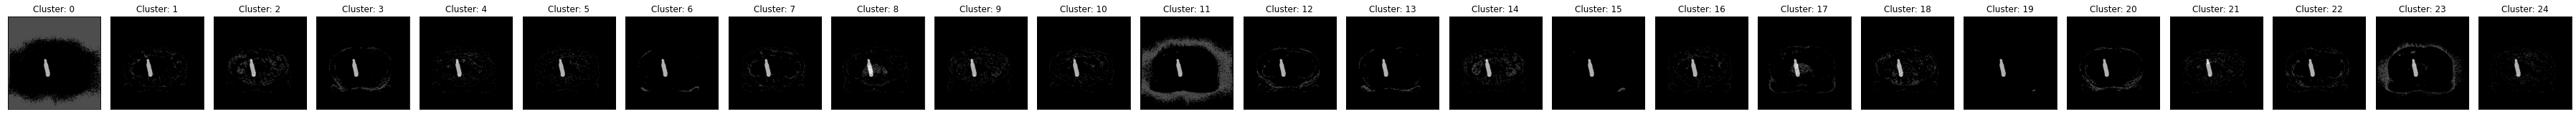

In [26]:
# Desenhar clusters separados + segmentação
fig, axs = plt.subplots(1, max_clusters, figsize=(max_clusters * 2, 6))
fig.patch.set_alpha(1)
for i in range(max_clusters):
	cluster_selecionado = i
	d = pd.DataFrame(linha['clusters']).applymap(lambda x: 1 if x == cluster_selecionado else 0)
	d = np.array(d.values).reshape(largura, altura)

	axs[i].imshow(d, cmap='gray')
	axs[i].imshow(segmentation_rle, cmap='gray', alpha=0.7)
	axs[i].set_title(f'Cluster: {cluster_selecionado}')
	axs[i].set_xticks([])
	axs[i].set_yticks([])

plt.tight_layout()

# 4) Separar clusters em imagens por pasta

[[0, 110682], [24, 258], [13, 196], [9, 136], [1, 110], [15, 88], [7, 52], [10, 30], [16, 23], [21, 20], [3, 5]]


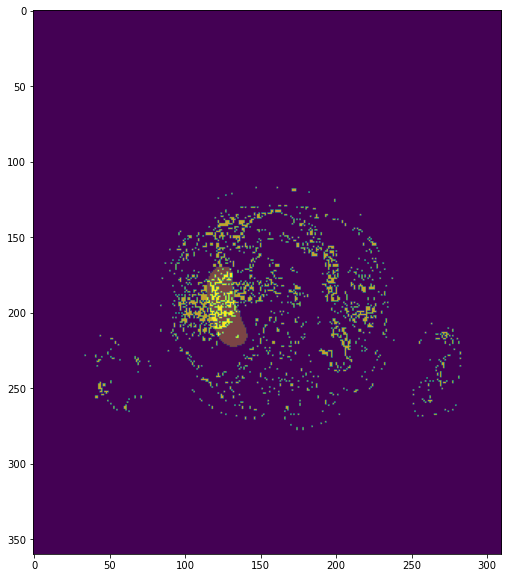

In [27]:
def comparar_cluster_linha(linha):
	largura, altura = linha['width'], linha['height']
	clusters = linha['clusters']
	segmentation = decode_rle(linha['segmentation'], shape=(altura, largura))

	# Transformar de matriz 2d para vetor 1d
	segmentation = segmentation.reshape(1, -1)

	# Pegar apenas os clusters que estão na segmentação
	clusters_segmentacao = clusters * segmentation
	clusters_selecionados = np.unique(clusters_segmentacao)

	# Contar quantos clusters existem na segmentação
	clusters_contagem = [
		[i, np.count_nonzero(clusters_segmentacao == i)]
		for i in clusters_selecionados
	]
	clusters_contagem = sorted(clusters_contagem, key=lambda x: x[1], reverse=True)
	print(clusters_contagem)

	# Retornar, de fato, o que tiver maior quantia ou o segundo maior para tentar ignorar o cluster que
	# seleciona o fundo?
	melhor_cluster = clusters_contagem[0]
	numero_cluster, _quantia = melhor_cluster
	return numero_cluster

# Buscar linha aleatória
linha = df_dados[df_dados['segmentation'].notnull()].sample(n=1).iloc[0]

plt.figure(figsize=(18, 10))
plt.imshow((linha['clusters'] == comparar_cluster_linha(linha)).reshape(linha['width'], linha['height']))
plt.imshow(decode_rle(linha['segmentation'], shape=(linha['height'], linha['width'])), alpha=0.3)
plt.show()

In [ ]:
# save_dataframe_as_feather(df_dados, 'train_imagens_clusters.feather')